In [4]:
import torch
from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')

# Hyperparameters

In [5]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
inv_mean = -mean
inv_std = 1/std
max_n = 100
batch_size = 32
learning_rate = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 40

# Loading Data (Taking Subset)

In [6]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean = mean, 
                                                            std = std)])

# For the purposes of visualizing images
inv_transforms = transforms.Compose([transforms.Normalize(mean = (0., 0., 0.),
                                                          std = inv_std),
                                     transforms.Normalize(mean = inv_mean,
                                                          std = (1., 1., 1,))])

cifar10 = datasets.CIFAR10(root = './data/', train=True, transform=train_transforms, download=True)

100%|██████████| 170498071/170498071 [00:14<00:00, 11723979.86it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/


In [7]:
cifar10_classes = cifar10.classes
images, labels = cifar10.data, cifar10.targets
labels = np.array(labels)

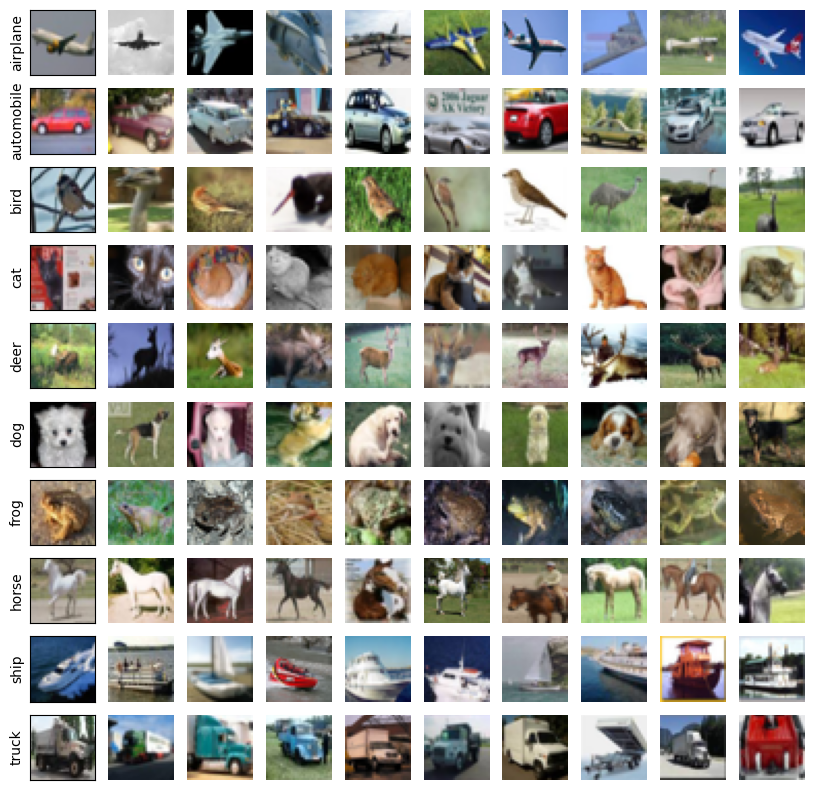

In [8]:
# Visualization
num_per_class = 10
fig, axes = plt.subplots(nrows=num_per_class, ncols=len(cifar10_classes), figsize = (10,10))
for idx, cls_name in enumerate(cifar10_classes):
    lbl_idxs = np.where(labels == idx)[0]
    for row in range(num_per_class):
        disp_idx = random.choice(lbl_idxs)
        img = images[disp_idx]
        axes[idx][row].imshow(img)
        if row == 0:
            axes[idx][row].set_ylabel(cls_name)
            axes[idx][row].set_xticks([])
            axes[idx][row].set_yticks([])
            continue
        axes[idx][row].axis('off')

In [9]:
data_idxs = []
for idx, cls_name in enumerate(cifar10_classes):
    lbl_idxs = np.where(labels == idx)[0]
    idxs = np.random.choice(lbl_idxs, max_n, replace=False)
    data_idxs.extend(idxs)

In [10]:
# DataLoader
class Cifar10(Dataset):
    def __init__(self, images, labels, idxs, transform = None):
        self.images = images[idxs]
        self.labels = labels[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        lbl = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, lbl
    
train_dataset = Cifar10(images, labels, data_idxs, train_transforms)
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, 
                         num_workers=16, pin_memory=True)

# Training Model

In [11]:
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(cifar10_classes))
model = model.to(device)

In [12]:
summary(model=model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
losses = []
accuracy = []
for epoch in range(1, epochs+1):
    pbar = tqdm(trainloader, total = len(trainloader), leave = False)
    epoch_loss = 0.0
    model.train()
    for imgs, lbls in pbar:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, lbls)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        pbar.set_postfix(train_loss = loss.item())

    # Epoch Loss
    epoch_loss = epoch_loss / len(trainloader)

    # Calculating Accuracy
    model.eval()
    no_of_correct, total = 0, 0
    with torch.no_grad():
        for imgs, lbls in trainloader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            out = model(imgs)
            _, preds = out.max(-1)
            no_of_correct += (preds == lbls).cpu().numpy().sum()
            total += len(lbls)
    
    epoch_accuracy = no_of_correct / total
    losses.append(epoch_loss)
    accuracy.append(epoch_accuracy)
    print(f"{'*'*10} EPOCH {epoch:2}/{epochs} {'*'*10}")
    print(f'''{"#"*33}
Train Loss: {epoch_loss:5.3f}, Train Accuracy: {epoch_accuracy*100:5.2f}
{"#"*33}''')


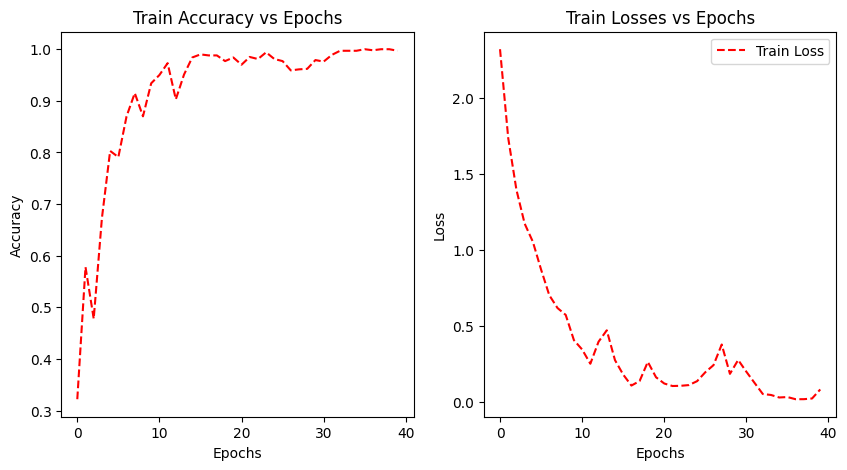

In [14]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.title('Train Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(accuracy, 'r--', label = 'Train Accuracy')
plt.subplot(122)
plt.title('Train Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(losses, 'r--', label = 'Train Loss')
plt.legend();

# Filter Weights Visualization

## Distribution of Weights

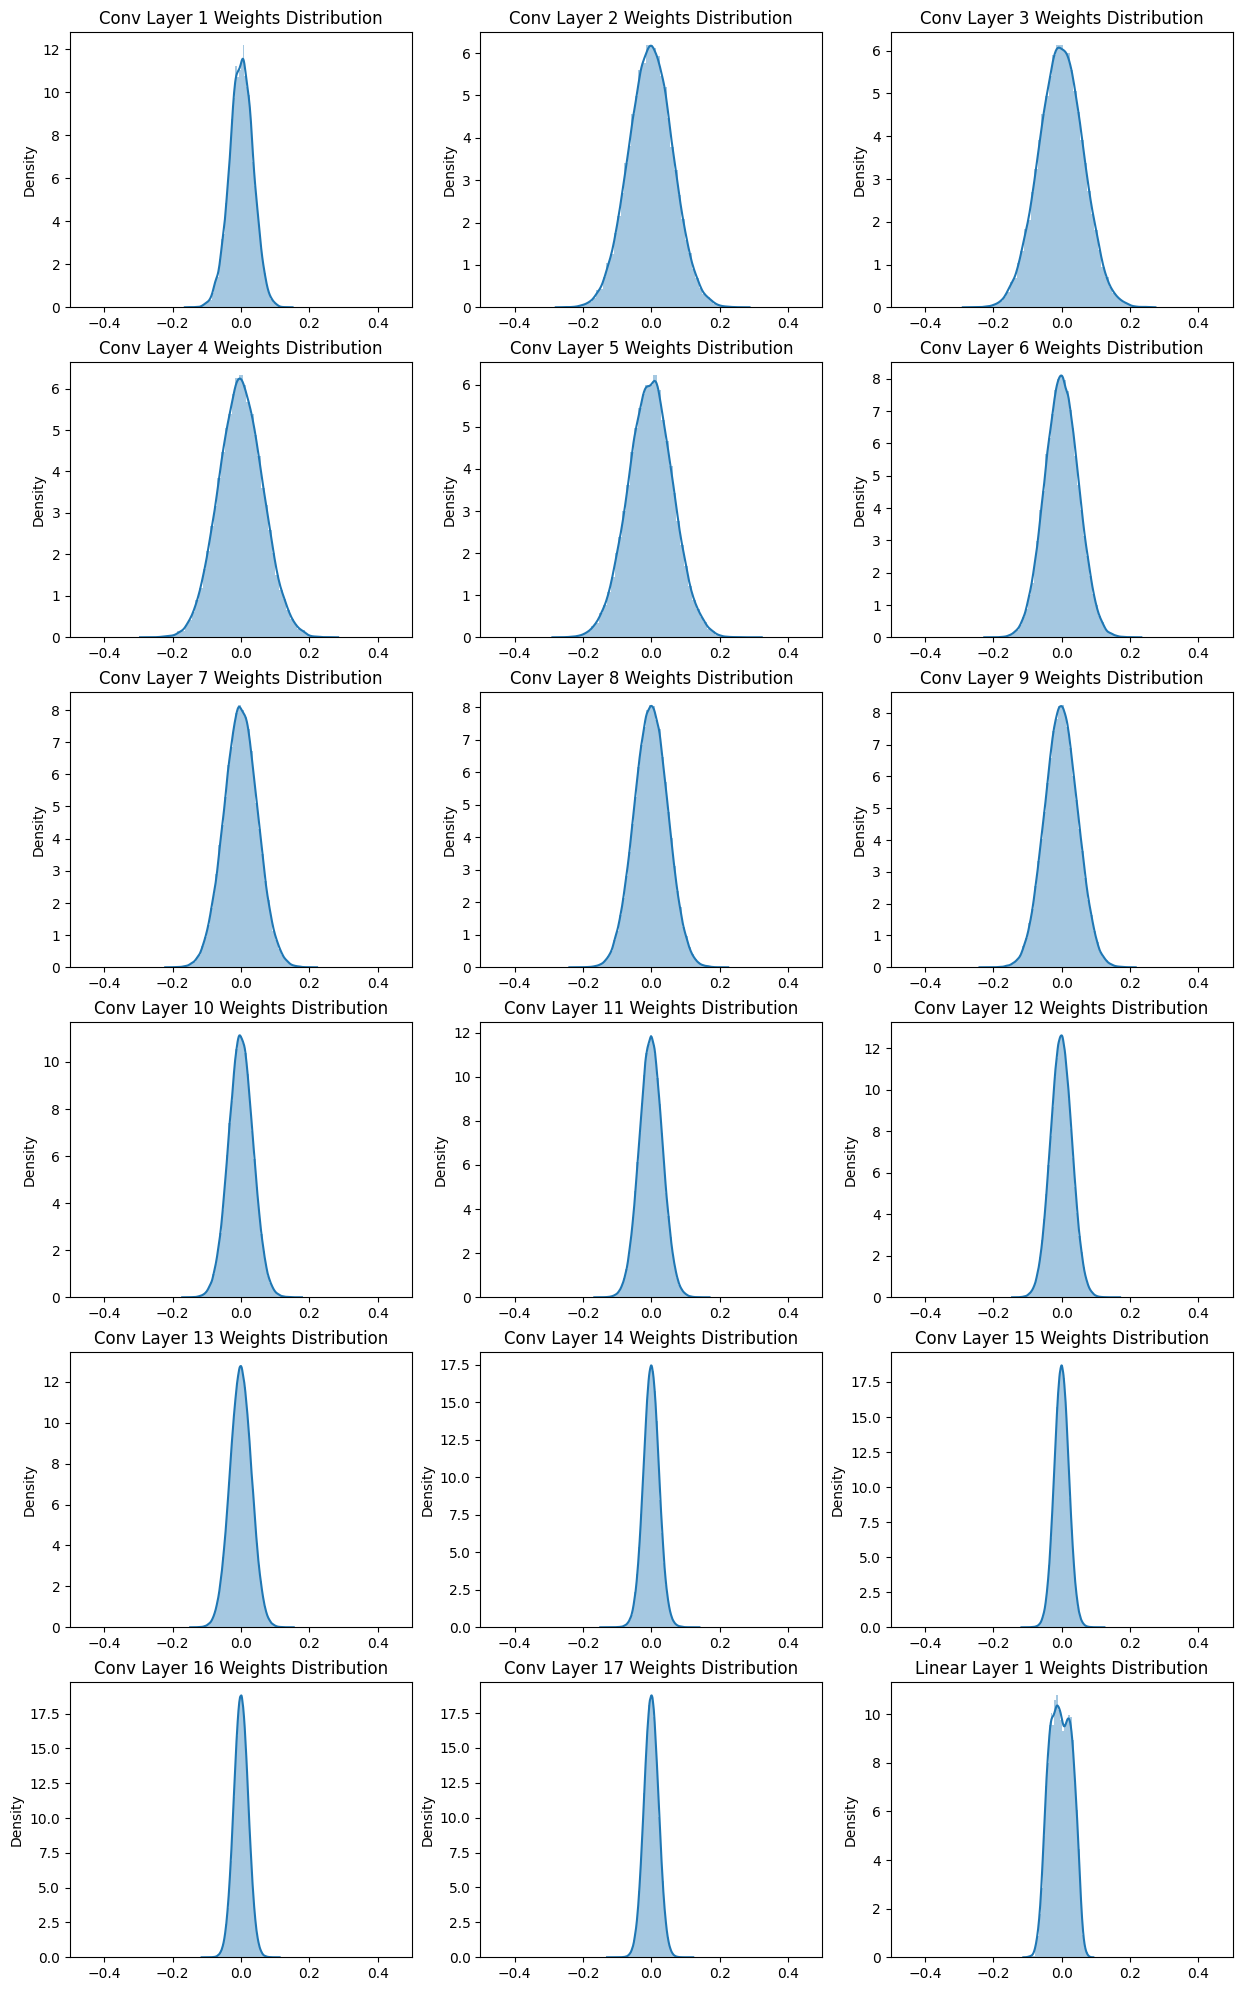

In [15]:
conv_layer = 1
lin_layer = 1
axis_index = 0
fig, axes = plt.subplots(nrows = 6, ncols = 3, figsize = (15,25))
for layer in model.named_modules():
    if layer[0].find('conv') != -1:
        layer_weights = layer[1].weight.cpu().detach().clone().numpy().reshape(-1,1)
        sns.distplot(x = layer_weights, ax = axes[axis_index // 3, axis_index % 3]).set(title=f"Conv Layer {conv_layer} Weights Distribution")
        axes[axis_index // 3, axis_index % 3].set_xlim(-0.5, 0.5)
        conv_layer+=1
        axis_index += 1

    # For added fully connected layer
    if layer[0].find('fc') != -1:
        layer_weights = layer[1].weight.cpu().detach().clone().numpy().reshape(-1,1)
        sns.distplot(x = layer_weights, ax = axes[axis_index // 3, axis_index % 3]).set(title=f"Linear Layer {lin_layer} Weights Distribution")
        axes[axis_index // 3, axis_index % 3].set_xlim(-0.5, 0.5)
        lin_layer+=1
        axis_index += 1